### End-to-End with Assembly.ai ###

### Input to Email ###

In [1]:
# !pip install wordcloud

In [2]:
#Data Manipulation
import pandas as pd
import datetime as dt
import numpy as np
# from rev_ai import *
# get_transcript()
#Visualization
import matplotlib.pyplot as plt
from chord import Chord
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Text manipulation
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from gensim.parsing.preprocessing import remove_stopwords
from rake_nltk import Rake
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

In [3]:
# import sys
# import time
# import requests

# filename = "TED_03.mp4"
 
# def read_file(filename, chunk_size=5242880):
#     with open(filename, 'rb') as _file:
#         while True:
#             data = _file.read(chunk_size)
#             if not data:
#                 break
#             yield data

# headers = {'authorization': "681814e18ef446d8a29a9c4fec447231"}
# response = requests.post('https://api.assemblyai.com/v2/upload',
#                          headers=headers,
#                          data=read_file(filename))

# #this is needed for the next call below - 'audio url'
# url = response.json()['upload_url']

# #print(response.json())

In [4]:
# #STEP 2
# #THIS CAN ALSO TAKE ONLINE HOSTED FILE WHERE URL CALL IS LOCATED

# import requests
# endpoint = "https://api.assemblyai.com/v2/transcript"

# json = {
#   "audio_url": f"{url}", 
#   'auto_highlights': True,
#   'speaker_labels': True
# }

# headers = {
#     "authorization": "681814e18ef446d8a29a9c4fec447231",
#     "content-type": "application/json"
# }

# response = requests.post(endpoint, json=json, headers=headers)
# id = response.json()['id']
# response.json()

In [5]:
# #STEP 3 - TO GET THE TRANSCRIPT
# # import requests

# endpoint = f"https://api.assemblyai.com/v2/transcript/{id}"

# headers = {
#     "authorization": "681814e18ef446d8a29a9c4fec447231",

# }

# response = requests.get(endpoint, headers=headers)
# status = response.json()['status']
# while status == 'queued' or status == 'processing':
#     response = requests.get(endpoint, headers=headers)
#     status = response.json()['status']

# transcript_json = response.json()

In [6]:
#Prints out the who json file
# transcript_json

In [7]:
# utterances_df = pd.DataFrame.from_dict(transcript_json['utterances'])
# utterances_df
# # utterances_df.to_csv('utterances.csv')

In [8]:
# df = pd.read_csv('utterances.csv')
# df['confidence'].mean()
df = pd.read_csv('diar_df_v1.csv')

In [9]:
# df.head()

In [10]:
df = df[['Speaker', 'Start', 'End', 'Sentences']]
# df = df.rename(columns = {'start':'Time', 'speaker': 'Speaker', "text": 'Text'})

# df['Time'] = pd.to_datetime(df['Time'], unit='ms')
# df['Time'] = pd.to_datetime(df['Time'], unit='ms')
# df['Time'] = df['Time'].astype('datetime64[ms]')
# df['Time'] = df["Time"].dt.strftime("%M:%S")
# pd.to_datetime(df['Time'],format = "%M:%S")
# df.head()

In [11]:
# df['time_delta'] = df['Time'].diff()
# df['time_delta'] = df['Time'].shift(periods = -1)

In [12]:
# df['time_spoken'] = df['Time'].diff()
df['talk_time'] = df['End'] - df['Start']
# df['talk_time'] = df['talk_time'].dt.total_seconds()

In [13]:
df.fillna(' ', inplace=True)

In [14]:
df['text_split'] = df['Sentences'].str.split()

In [15]:
df['num_words_spoken'] = df['text_split'].str.len()

In [16]:
# df.groupby(['Speaker']).count()

In [17]:
df['word_per_sec'] = df['num_words_spoken']/df['talk_time']
df.head()

,Speaker,Start,End,Sentences,talk_time,text_split,num_words_spoken,word_per_sec
0,A,0.443844,0.914656,This is William.,0.470812,"[This, is, William.]",3,6.371963
1,B,0.914656,4.757094,"Hey, again, London. This is David Miller. And ...",3.842437,"[Hey,, again,, London., This, is, David, Mille...",13,3.383269
2,A,7.210719,7.629219,,0.418500,[],0,0.000000
3,B,8.754781,60.790531,The great thing about last night's general ele...,52.035750,"[The, great, thing, about, last, night's, gene...",164,3.151679
4,A,61.018344,120.811531,"The question is, how did the first election de...",59.793188,"[The, question, is,, how, did, the, first, ele...",151,2.525371


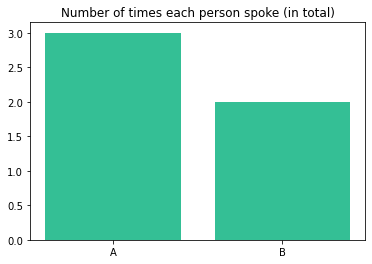

In [18]:
# How many times did each person speak?
times_each_spoke = pd.crosstab(df['Speaker'], columns = 'Speaker')
times_each_spoke = times_each_spoke['Speaker'].sort_values(ascending = False)
names = times_each_spoke.index
plt.bar(x = names, height=times_each_spoke, color = '#34bf95')
plt.title('Number of times each person spoke (in total)')
plt.show()

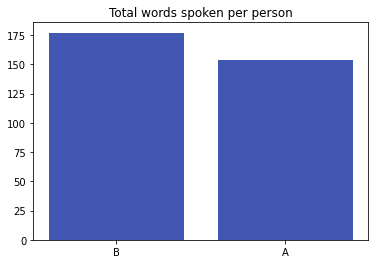

In [19]:
#How many total words did each person speak?
total_words = df.groupby('Speaker').sum()[['num_words_spoken']]
total_words = total_words.sort_values(by = 'num_words_spoken', ascending = False)
names = total_words.index
plt.bar(x = names, height=total_words['num_words_spoken'], color = '#4257b2')
plt.title('Total words spoken per person')
plt.show()

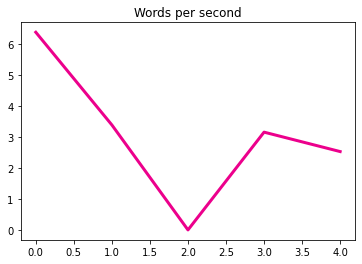

In [20]:
#Words per sec
x = df.index
y = df['word_per_sec']

plt.plot(x, y, linewidth=3, color = '#ec008c')
plt.title('Words per second')
plt.show()

In [21]:
#Get chord diagram
links = df.loc[:, ('Speaker', 'num_words_spoken')]
links['Target'] = links['Speaker'].shift(periods=-1)
links['num_words_received'] = links['num_words_spoken'].shift(periods = 1)
links["Speaker"] = links["Speaker"].astype('category')
links['Speaker_cat'] = links['Speaker'].cat.codes
links["Target"] = links["Target"].astype('category')
links['Target_cat'] = links['Target'].cat.codes

# This needs to be a function!!! Time & Classification of the sentences
# Time & person
#the input should be the result of an equations (# of words/ unit of time) - Bidirectional
crosstab = pd.crosstab(links['Speaker'], links['Target'])

names = crosstab.index.to_list()
matrix = crosstab.values.tolist()

chord = Chord(matrix, names, colors="d3.schemeSet1",opacity=0.8,
        padding=0.001,
        width=900,
        label_color="#454545",
        wrap_labels=True,
        margin=0,
        credit=True,
        font_size="20px",
        font_size_large="18px")

chord.show()
# chord.to_html('NAME.html')

### 2. TEXTUAL ANALYSIS: Analyzing the text ###

### 3. SUMMARIZATION: The Main Point ###

In [22]:
# nlp = spacy.load("en_core_web_sm")
nlp = en_core_web_sm.load()

# Create master transcript from df['Text']
keywords = []
for i in df['Sentences']:
    keywords.append(i)
    
#Convert list to string
keywords = ' '.join([str(item) for item in keywords])

# Remove stopwords
no_stop = remove_stopwords(keywords)

#Create stopwords object
doc = nlp(no_stop)

#The sentence that summarizes the article;

#Today's class in a sentence or two...
summary = summarize(keywords, ratio  = .1)
summary = summary.split('.')[0]
# summary = summary.split('?')[0]

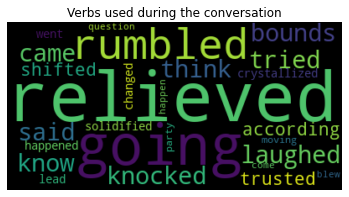

In [23]:
Verbs = ''
for word in doc:
    if word.pos_ in ['VERB']:
        Verbs = ' '.join((Verbs, word.text.lower()))
        
wordcloud = WordCloud(stopwords=STOPWORDS).generate(Verbs)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Verbs used during the conversation")
plt.show()

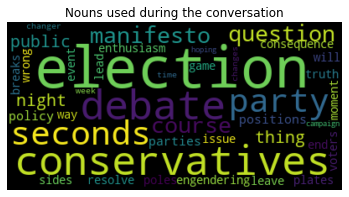

In [24]:
Nouns = ''
for word in doc:
    if word.pos_ in ['NOUN']:
        Nouns = ' '.join((Nouns, word.text.lower()))
        
wordcloud = WordCloud(stopwords=STOPWORDS).generate(Nouns)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nouns used during the conversation")
plt.show()

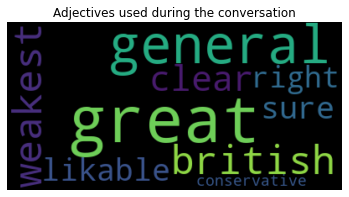

In [25]:
Adjectives = ''
for word in doc:
    if word.pos_ in ['ADJ']:
        Adjectives = ' '.join((Adjectives, word.text.lower()))
        
wordcloud = WordCloud(stopwords=STOPWORDS).generate(Adjectives)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Adjectives used during the conversation")
plt.show()
# plt.savefig('adjectives.png')

In [27]:
import re
pattern = re.compile(r'\s[A-Za-z\s]*\?')
pattern = pattern.findall(keywords)
num_questions = len(pattern)

if num_questions == 1:
    print(f"1. There was 1 question asked during this conversation.\n")
else:
    print(f"1. There were {num_questions} questions asked during this conversation.\n")
    
#What were the questions that were asked?
for i,j in enumerate(pattern):
    print(f"Question #{i}: {j[1:].upper()}")
    
#Who asked the most questions?
speaker_text = df[['Speaker', 'Sentences']]
who_asked = speaker_text.loc[speaker_text['Sentences'].str.contains('\?')]
who_asked = who_asked['Speaker'].value_counts()

for i, j in zip(who_asked.index, who_asked):
    if j == 1:
        print(f"\n{i} asked {j} question.")
    else:
        print(f"\n{i} asked {j} questions.")
        


#What's the most influential sentence in the conversation
# summary
print(f'\n2. Meeting Summary & Headline: \n\n"{summary}." \n')


# highlights = [transcript_json['auto_highlights_result'].
#               get('results')[i]['text'] for i in range(len(transcript_json['auto_highlights_result'].
#                                                            get('results')))]

# print(f"3. Important phrases:\n")
# for i in highlights:
#     print(f"'{i}'")

# summarize(keywords, ratio  = .01)
# print(f'4. Below is a transcript of your conversation: \n\n {keywords}')

1. There were 2 questions asked during this conversation.

Question #0: HOW DID THE FIRST ELECTION DEBATE GO BETWEEN BORIS JOHNSON AND JEREMY CORBYN?
Question #1: BUT IS IT AN EVENT THAT WILL HAVE CHANGED THE COURSE OF THIS ELECTION SO FAR?

A asked 1 question.

2. Meeting Summary & Headline: 

"Boris Johnson, they laughed when he said that his fidelity to the truth could know no bounds and Jeremy Corbyn when he tried to say he had a clear policy on Brexit." 



### 4. RECOMMENDATION: Keywords for recommendation ###
Requirements: Needs to be string; concat list separate by spaces

In [28]:
# transcript_json['auto_highlights_result']

In [29]:
#3 Most important words in the doc
items = [x.text for x in doc.ents]
word = Counter(items).most_common(5)

#Extracting top 5 keywords/phrases from rake
r = Rake()
r.extract_keywords_from_text(keywords)

# r.get_ranked_phrases()[0:1]
search_keywords = r.get_ranked_phrases()[0:5]

In [30]:
#Keywords for automatic web search
num_search_terms = ['1st','2nd','3rd','4th','5th','6th', '7th', '8th', '9th', '10th']

for i,j in zip(search_keywords, num_search_terms):
    print(f'The {j} search term is "{i}"')

The 1st search term is "corbin came across according"
The 2nd search term is "great british public rumbled"
The 3rd search term is "first election debate go"
The 4th search term is "yet crystallized around"
The 5th search term is "party manifestos come"


In [31]:
keywords.lower().split('.')[1]

' hey, again, london'